In [ ]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

resources_path = Path('../../Resources/').resolve() # change this to the local path of the course package
sys.path.append(str(resources_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= resources_path / 'introdl')

In [1]:
# imports and configuration

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, mean_absolute_error

import torch
import torch.nn as nn
from torch.optim import AdamW, SGD
from torch.utils.data import TensorDataset, DataLoader

from introdl.utils import get_device, load_results, create_CIFAR10_loaders, config_paths_keys
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


# Resuming Training and Early Stopping

In this notebook, we will describe how to use `train_network` to resume training from a saved checkpoint file. We will also discuss early stopping, how it works, and how it is implemented in `train_network`. We will demonstrate these concepts using the 2D classification example from Lesson 1.

Here is a video walkthrough of this notebook: [L03_5_Early_Stopping](https://share.descript.com/view/0kFaJKcGgDa).

## Resuming Training

To understand how resuming training works lets look at what's in one of our checkpoint files.  Here is the function we use internally to save a checkpoint:

```python
def save_checkpoint(epoch, model, optimizer, results, checkpoint_file, lr_schedule=None):
    """Save model, optimizer, and scheduler states along with results to a checkpoint."""
    save_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'results': results
    }
    if lr_schedule is not None:
        save_dict['lr_scheduler_state_dict'] = lr_schedule.state_dict()
    torch.save(save_dict, checkpoint_file)
```

We save current epoch, the model parameters, the state of the optimizer (adapted learning rates and other values), the performance metrics, and the learning rate scheduler state if there is one.  All of those things are restored when we load a checkpoint file so that we can pickup training exactly where we left off.  Moreover, the checkpoint file contains the trained model parameters so we can load them for later making predictions and the performance metrics can be used to later evaluate the model.  It's not hard to write code to do all of that, especially if you have some assistance from an AI, but it's far easier to use something like `train_network` or to use the tools built in an ecosystem like PyTorch Lightning or Hugging Face.

### Key Benefits of Resuming from a Checkpoint
* **Saves Time:** Allows long training processes to be split into multiple sessions without restarting from scratch.
* **Maintains Continuity:** Restores model weights, optimizer states, and learning rate schedules, preserving the learning state.
* **Consistent Tracking:** Reloads epoch, training time, and historical results, ensuring metrics continue without interruption.

### Two Approaches to Resuming Training

In `train_network`, there are two methods for resuming training from a checkpoint, depending on whether you want to overwrite the original checkpoint file or save the continued training results in a new file:


1. **Resume and Overwrite Original Checkpoint**:
   - **Usage**: Specify the `checkpoint_file` and set `resume_checkpoint=True`. The training resumes from the state in `checkpoint_file`, and as training progresses, the checkpoint file is continuously updated with new results.
   - **Effect**: The original checkpoint is overwritten with the continued training progress, and no separate checkpoint is created for the resumed session.

2. **Resume from One File, Save to Another**:
   - **Usage**: Specify both `resume_file` (the file to resume from) and `checkpoint_file` (the file to save continued results). The training resumes from `resume_file`, but continued progress is saved to a new checkpoint file specified by `checkpoint_file`.
   - **Effect**: This method preserves the original checkpoint in `resume_file` and saves the new training results in a separate file, `checkpoint_file`.

### Pseudo-code Examples

#### Example 1: Resume and Overwrite Original Checkpoint

```python
# Approach 1: Overwrite the checkpoint file with continued training results
checkpoint_file = "model_checkpoint.pt"
resume_checkpoint = True  # Enable resuming from the checkpoint file

# Pseudo-call
train_network(
    model=model,
    loss_func=loss_func,
    train_loader=train_loader,
    checkpoint_file=checkpoint_file,  # File used for both resuming and saving
    resume_checkpoint=resume_checkpoint  # Overwrites checkpoint_file with new results
)
```

#### Example 2: Resume from One File, Save to Another

```python
# Approach 2: Use one file for resuming, another for saving continued training
resume_file = "initial_checkpoint.pth"   # Load model state from this file
checkpoint_file = "continued_training.pt"  # Save new progress here

# Pseudo-call
train_network(
    model=model,
    loss_func=loss_func,
    train_loader=train_loader,
    resume_file=resume_file,         # File to resume training from
    checkpoint_file=checkpoint_file, # File to save new training progress
    resume_checkpoint=True           # Enable resuming from resume_file
)
```

Resuming training from checkpoints is super useful when you're experimenting and you're not sure how many epochs to use for training.  For example, suppose we want to train the 2D classification model from Lesson 1.

In [12]:
# Prepare the loaders for the circles dataset
X_train, y_train = make_circles(n_samples=1000, factor=0.3, noise=0.2, random_state=123)
X_test, y_test = make_circles(n_samples=200, factor=0.3, noise=0.2)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=50)

# Define the model
class CirclesClassifier(nn.Module):
    def __init__(self):
        super(CirclesClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 6),
            nn.Tanh(),
            nn.Linear(6, 2), # changed the number of outputs to match next layer
            nn.Tanh(),
            nn.Linear(2, 2)
        )

    def forward(self, x):
        return self.model(x)
    
# set up the optimizer and training, this time we'll use AdamW
model = CirclesClassifier()
loss_func = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01) # using a higher learning rate as per Neural Net Playground

score_funcs = {'ACC':accuracy_score}

device = get_device()

ckpt_file = MODELS_PATH / 'L03_circles_classifier.pt'

Now if training were slow or expensive we might want to try a few epochs and then check the results.  For this problem let's try 20 epochs.

Epoch: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s, train_loss=0.694, val_loss=0.694]


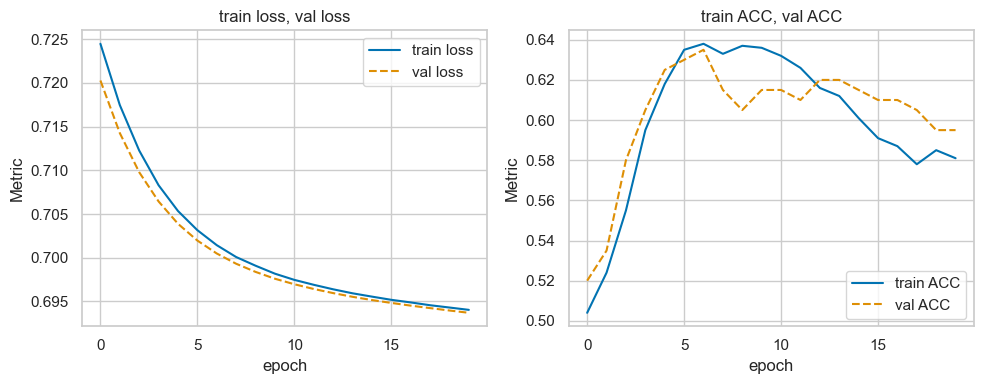

In [13]:
results = train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = 20,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    resume_checkpoint = False);

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

It looks like the performance metrics can still improve.  Now run the cell below a few times until you're satisfied with the results.  Each time you run it you'll add 20 epochs and overwrite the previous checkpoint file.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s, train_loss=0.184, val_loss=0.171]


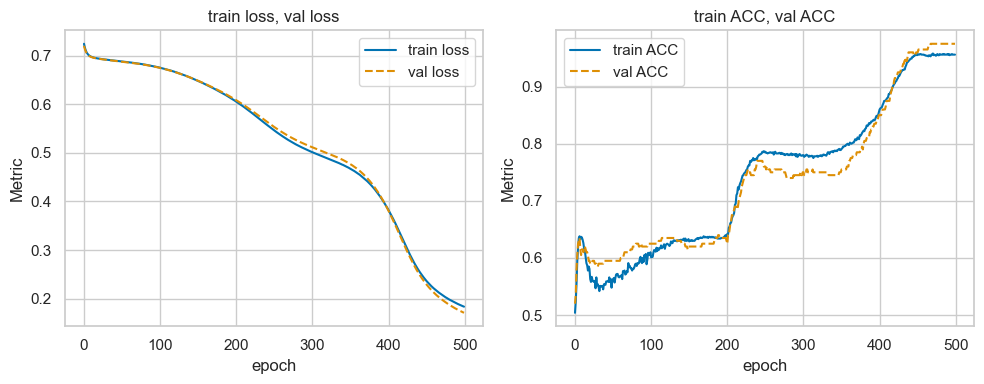

In [37]:
results = train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = 20,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file,
    resume_checkpoint = True);

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

I ended up executing the cell over 20 times,  but your results will vary.  Part of the issue is that stochastic gradient descent just isn't a great optimizer for this problem.  Try changing the optimizer to AdamW and see what happens!

## Early Stopping

Let's revisit the training we did for the `SimpleCNN` model using `AdamW` in a previous notebook (without data augmenation).  The next cell shows the performance metrics:

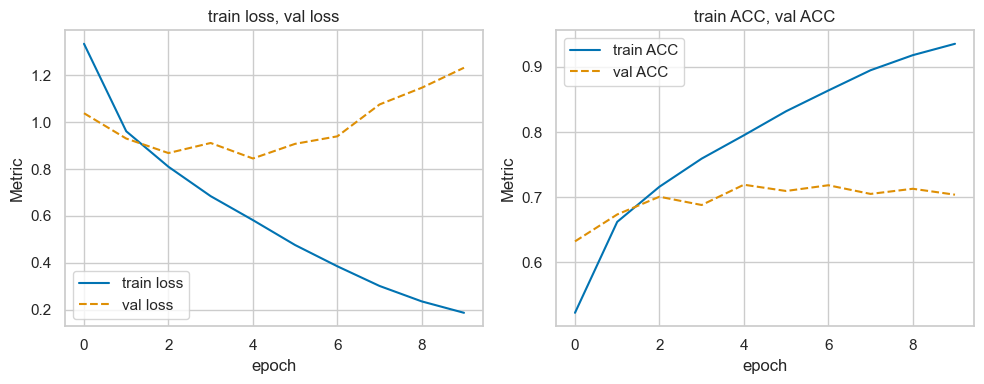

In [5]:
results = load_results(MODELS_PATH / 'L03_CIFAR10_SimpleCNN_AdamW_defaults.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

There's not much point in training past epoch 3 here (which is the 4th epoch due to Python indexing), the validation loss only increases and the accuracy doesn't change much.  Moreover, the gap between the training and validation metrics increases.  If we were to monitor a during training we could decide to stop if there is no progress in the metric for a while.  That's the idea behind **early stopping.**


### Early Stopping Description

Early stopping is a technique to prevent overfitting by monitoring a specific metric during training—such as validation loss or another evaluation score— and stopping when there is no improvement in this metric for a specified number of epochs, known as the **patience**.

In our implementation, early stopping works as follows:

1. **Monitored Metric (`early_stop_metric`)**: Each epoch, the performance is evaluated based on `early_stop_metric` (e.g., `"loss"` or a metric from `score_funcs`). This metric determines if training should continue or stop.
   
2. **Improvement Criterion**: We check if `early_stop_metric` has improved based on a criterion (`early_stop_crit`), which can be `"min"` (to minimize the metric) or `"max"` (to maximize it). If improvement is detected, the metric is recorded as the new best, and the patience counter is reset.

3. **Patience**: If there is no improvement in `early_stop_metric`, the patience counter increments. When this counter reaches the patience limit, training stops early.

4. **Checkpointing**: Each time a new best value for `early_stop_metric` is achieved, a checkpoint file is saved. This checkpoint corresponds to the model’s best performance on the monitored metric, not necessarily the final epoch, ensuring that the best-performing model is retained.

### Pseudo-Code Example

```python
# Initialize best_metric and patience counter
best_metric = float('inf') if early_stop_crit == "min" else -float('inf')
no_improvement = 0

for epoch in range(epochs):
    # Train the model for one epoch
    
    # Evaluate on validation set
    val_metric = evaluate_metric(model, val_loader)  # Example for validation loss or accuracy
    
    # Check if `val_metric` is better than `best_metric`
    if (early_stop_crit == "min" and val_metric < best_metric) or \
       (early_stop_crit == "max" and val_metric > best_metric):
       
        # Update best metric and reset patience counter
        best_metric = val_metric
        no_improvement = 0

        # Save a checkpoint for this best model
        save_checkpoint(model, epoch)
    else:
        # Increment patience counter if no improvement
        no_improvement += 1
        
        # Stop if patience limit reached
        if no_improvement >= patience:
            print("Early stopping triggered.")
            break
```

This approach helps prevent overfitting by stopping once `early_stop_metric` plateaus on the validation set, rather than continuing to optimize only on the training data. The checkpointed model corresponds to the epoch with the best recorded `early_stop_metric` value, ensuring that the saved model reflects peak performance.

### Early Stopping Demonstration with CIFAR-10

We'll show how to apply early stopping to training our SimpleCNN model using AdamW and train_network.  We're doing this without data augmentation for demonstration. The next cell is just the loader and model setup.

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

train_loader, valid_loader, test_loader = create_CIFAR10_loaders(data_dir=DATA_PATH, use_augmentation=False, num_workers=4)
# you might have to reduce num_workers depending on your system

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Now we'll apply early stopping to the validation loss with patience=3.  A few things to note:

* You must have a validation loader to use early stopping.
* `early_stop_metric` defaults to None so just don't include it if you don't want to use early stopping.
* `early_stop_crit` defaults to 'min' so if you want to monitor loss you don't need to specify anything else.
* `early_stop_patience` defaults to 3 so we don't need to specify anything.

In [7]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L03_CIFAR10_SimpleCNN_earlystop.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file,
                early_stop_metric = 'loss')

cuda


Epoch:  70%|███████   | 7/10 [00:31<00:13,  4.51s/it, train_loss=0.283, val_loss=1.09] 

Early stopping at epoch 7


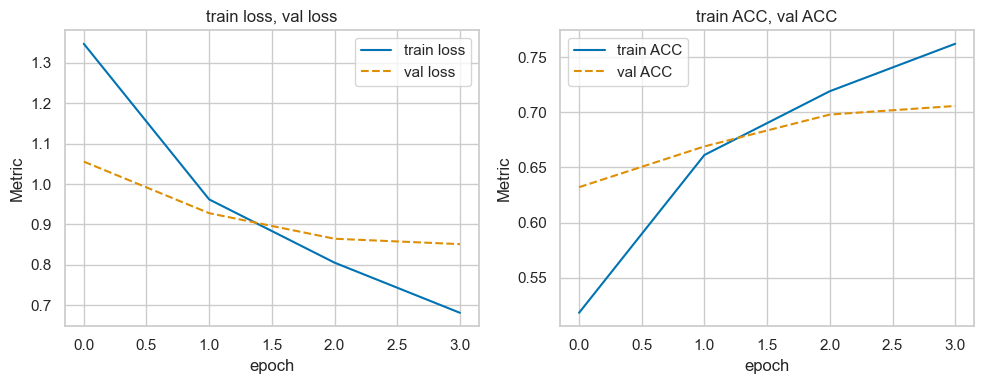

In [8]:
results = load_results(MODELS_PATH / 'L03_CIFAR10_SimpleCNN_earlystop.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

So the saved model is from the epoch 4 (0-indexed) even though the training stopped after the seventh epoch.  That's because there was no decrease in the loss for 3 epochs.

The next cell shows how we could monitor accuracy (ACC) instead.  Since we want maximum accuracy we'll specify `early_stop_crit='max'`.

In [9]:
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file =  MODELS_PATH / 'L03_CIFAR10_SimpleCNN_earlystop_ACC.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                val_loader=valid_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file,
                early_stop_metric = 'ACC',
                early_stop_crit='max')

cuda


Epoch: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it, train_loss=0.124, val_loss=1.4] 


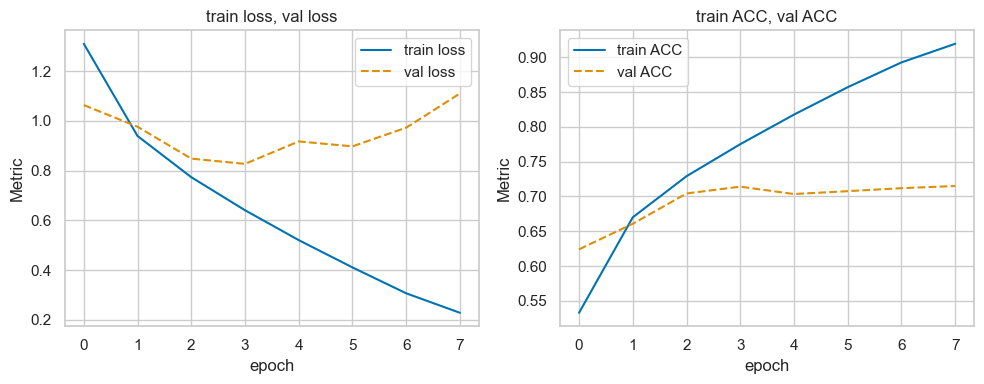

In [10]:
results = load_results(MODELS_PATH / 'L03_CIFAR10_SimpleCNN_earlystop_ACC.pt')

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

You can use early stopping whenever you like.  It never hurts anything and it often reduces overfitting by saving the model before the training and validation metrics diverge further.  If you decide you should train further you can always resume training from the saved checkpoint file.